# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# import statements and misc. functions

In [1]:
# import statements
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def show_image(img, gray=True, bgr=False, title='image'):
    if bgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 7))
    if gray == True:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title, fontsize=20)

## Calibrate Camera

Find object points and image points

In [3]:
## load calibration images
chess_images = glob.glob('camera_cal/calibration*.jpg')

## create object points 
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

## create lists to use in camera calibration
obj_points = []
image_points = []

for image in chess_images:
    
    ## convert to grayscale
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corners were found, add obj and image points
    if ret == True:
        obj_points.append(objp)
        image_points.append(corners)
        
        # draw and display corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey()
    
# cv2.destroyAllWindows()  

Calculate camera matrix and distortion coefficients

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, (1280, 720), None, None)

# Undistort function

In [5]:
# undistort any image from this camera using previously found matrix and undistort coeffictions
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

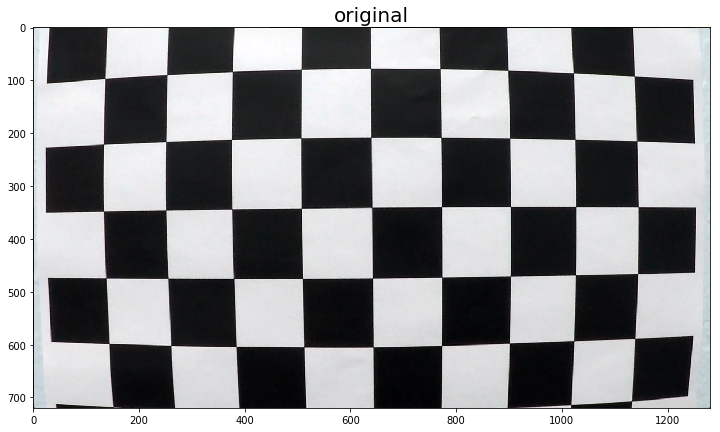

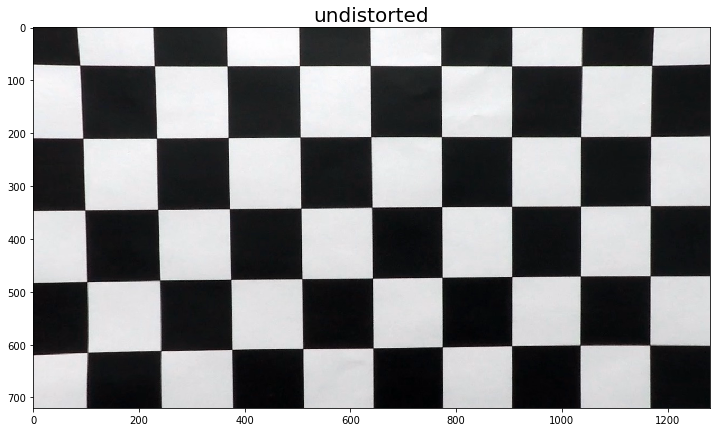

In [6]:
chess_images = glob.glob('camera_cal/calibration*.jpg')
img = cv2.imread(chess_images[0])

show_image(img, title='original')
und = undistort(img, mtx, dist)
show_image(und, title='undistorted')

# Thresholding functions

functions to take various thresholds: x gradient, y gradient, magnitude, direction, and multiple colorspaces

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # choose direction of gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise Exception('Orient must be x or y')
    
    # get absolute value of gradient image and scale to 8 bit
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    
    # binarize output image based on chosen threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [8]:
## must be jpg, not png 

def hls_thresh(img, channel='h', thresh=(0, 255)):
    
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # choose channel h, l, or s
    if channel == 'h':
        selected_channel = hls[:,:,0]
    elif channel == 'l':
        selected_channel = hls[:,:,1]
    elif channel == 's':
        selected_channel = hls[:,:,2]
    else:
        raise Exception('Channel must be h, l, or s')
    
    # binarize output base on chosen threshold
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel >= thresh[0]) & (selected_channel <= thresh[1])] = 1
    
    return binary_output

In [9]:
## must be jpg, not png

def bgr_thresh(img, channel='r', thresh=(0,255)):
    
    # choose channel r, g, or b
    if channel == 'r':
        selected_channel = img[:,:,2]
    elif channel == 'g':
        selected_channel = img[:,:,1]
    elif channel == 'b':
        selected_channel = img[:,:,0]
    else:
        raise Exception('Channel must be r, g, or b')
    
    # binarize output based on chosen threshold
    binary_output = np.zeros_like(selected_channel)
    binary_output[(selected_channel >= thresh[0]) & (selected_channel <= thresh[1])] = 1
    
    return binary_output

# TESTING

Testing threshold values

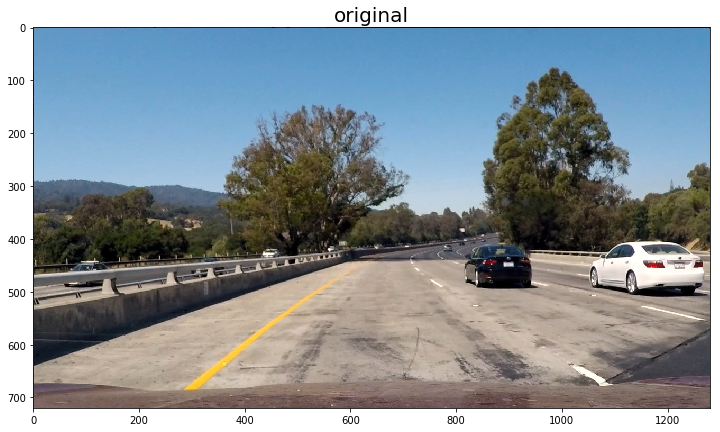

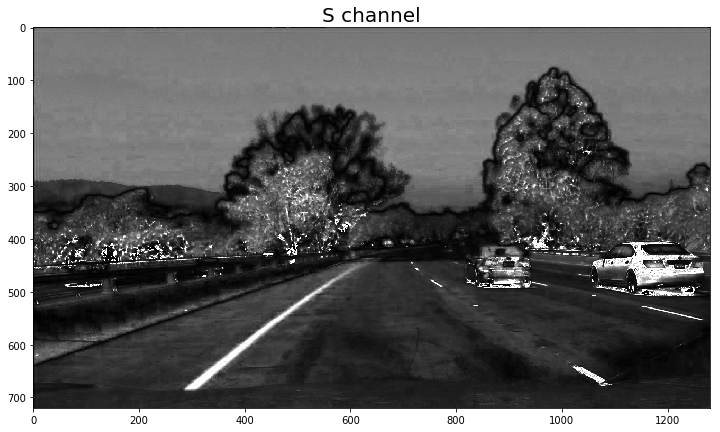

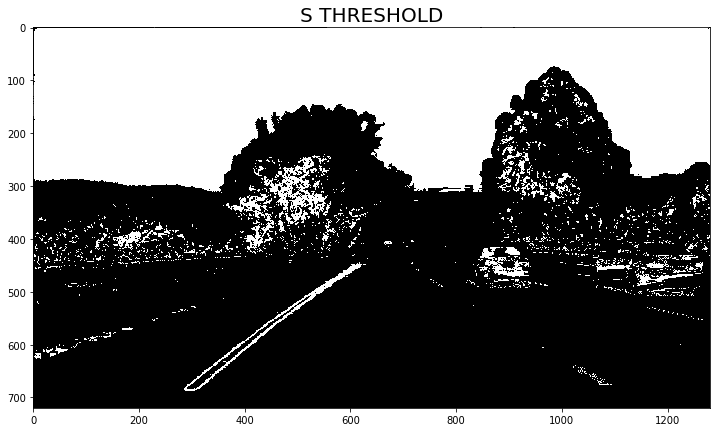

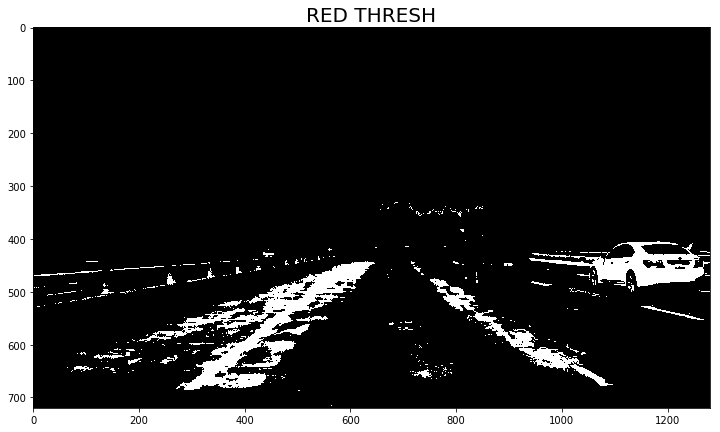

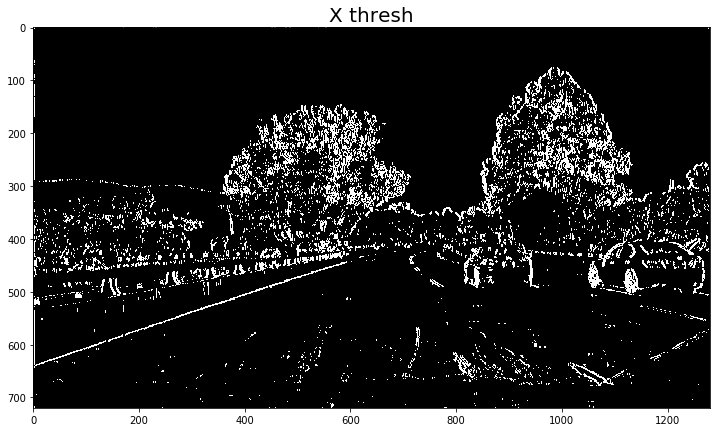

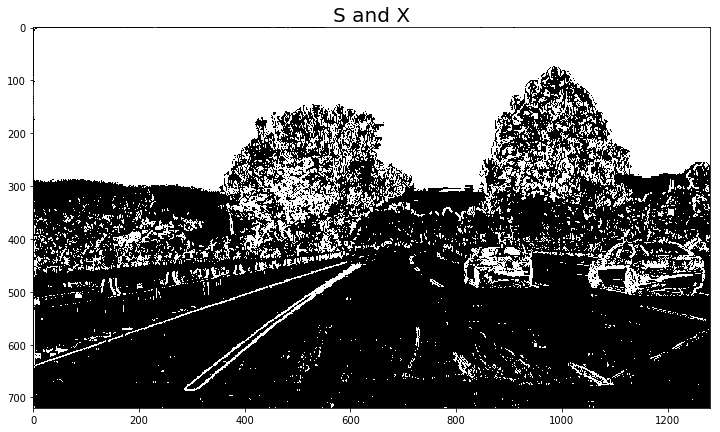

In [10]:
# choose image
test_images = glob.glob('test_images/*.jpg')
num = 2
img = cv2.imread(test_images[num])

# transform/threshold image
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

sobel_x = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(20, 255))
R_thresh = bgr_thresh(img, channel='r', thresh=(200,255))
S_thresh = hls_thresh(img, channel='s', thresh=(100, 240))
combined = np.zeros_like(sobel_x)
combined[(S_thresh == 1) | (sobel_x == 1)] = 1

# display images
show_image(img, title='original', bgr=True)
show_image(hls[:,:,2], title='S channel')
show_image(S_thresh, gray=True, title='S THRESHOLD')
show_image(R_thresh, gray=True, title='RED THRESH')
show_image(sobel_x, gray=True, title='X thresh')
# show_image(sobel_x, gray=True, title='x thresh')

show_image(combined, gray=True, title='S and X')

# Perspective transform

change perspective to bird's eye view to see lane lines as parallel

In [11]:
# input values: np.float32([[width, height], [w,h], [w,h], [w,h]])
# order: top_left, top_right, bottom_right, bottom_left
# return M_inv for drawing lines on video

def warp_perspective(image, src, dest):
    # define image size for warpPerspective
    image_size = (image.shape[1], image.shape[0])
    
    # get transformation matrix based on source and destination points
    M = cv2.getPerspectiveTransform(src, dest)
    
    # get inverse matrix in order to transform back to original perspective
    M_inv = cv2.getPerspectiveTransform(dest, src)
    
    # warp the perspective of the image
    img = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_NEAREST)
    
    return img, M_inv

# TESTING
Test src and dest values

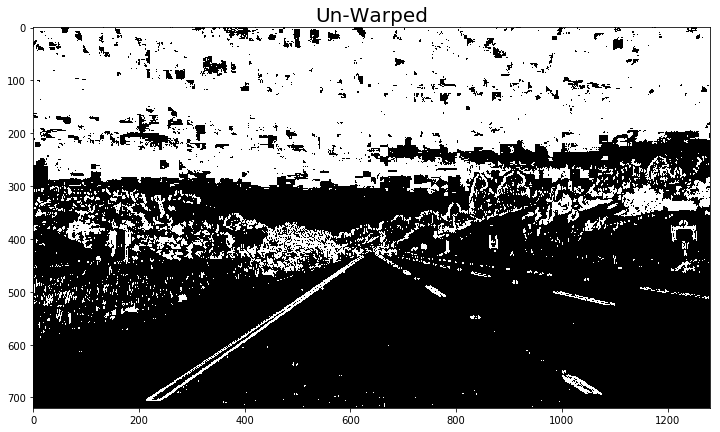

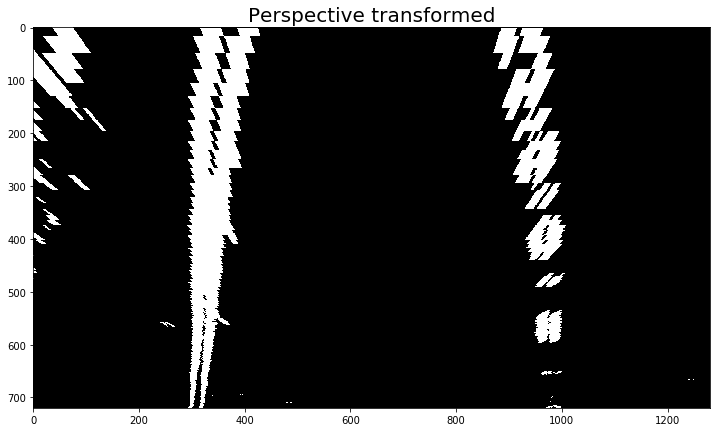

In [12]:
# choose image to load
test_images = glob.glob('test_images/*.jpg')
num = 0
img = cv2.imread(test_images[num])

# undistort image
undistorted = undistort(img, mtx, dist)

# binary image
sobel_x = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=5, thresh=(20, 255))
S_thresh = hls_thresh(undistorted, channel='s', thresh=(100, 240))
combined = np.zeros_like(sobel_x)
combined[(S_thresh == 1) | (sobel_x == 1)] = 1

# define source points
tls = [605, 440]
trs = [675, 440]
brs = [1045, 670]
bls = [270, 670]

# define destination points
tld = [300,0]
trd = [1000,0]
brd = [1000,img.shape[0]]
bld = [300,img.shape[0]]

# define src and dest as np.float32 array
src = np.float32([tls, trs, brs, bls])
dest = np.float32([tld, trd, brd, bld])

# warp image
warped, M_inv = warp_perspective(combined, src, dest)

# define polygon to draw
poly = np.int32(src)
poly2 = np.int32(dest)

# draw lines on each image
cv2.polylines(combined, [poly], True, (0,0,255))
cv2.polylines(warped, [poly2], True, (0,0,255))

show_image(combined, title='Un-Warped')
show_image(warped, title='Perspective transformed')

# Detecting Lane Lines


Find histogram peaks to locate starting x values of each lane

In [13]:
# INPUT: warped binary image 
def hist_peak(image):
    # isolate bottom half of the image
    half = image.shape[0] // 2
    bottom_half = image[half:, :]
    
    # define histogram based on vertical sum of the bottom half of the image
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

Main function to fit polynomial

In [14]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    # if a previous lane line was NOT detected, start from scratch using window search
    # if a lane line WAS detected, search around the area of the previously detected line using search_around_poly()
    if (left_line.detected == False) or (right_line.detected == False):
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    else:
        leftx, lefty, rightx, righty = search_around_poly(binary_warped)
        
     # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ### Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    ## calculate base X position of each line using current polynomial fit and max Y position (719)
    left_line.line_base_pos = left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2]
    right_base = right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2]
    
    # set limit for right lane line
    ## SOLVES BOTTOM RIGHT LANE PROBLEM AT ~42 SECONDS
    # if right position is below 980 discard fit
    if right_base < 980:
        right_fit = right_line.current_fit
    else:
        right_line.line_base_pos = right_base
    
    # set object variables to left and right fit coefficients in both pixels and meters
    left_line.current_fit = left_fit
    left_line.current_fit_meters = left_fit_meters
    right_line.current_fit = right_fit
    right_line.current_fit_meters = right_fit_meters
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_line.detected = True
        
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line.detected = True
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

Find lane pixels using sliding window search

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist_peak(binary_warped)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


Find lane pixels using previous fit heuristic

In [16]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    margin = 50
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### create lane indices based on area around previous polynomial fit
    
    # load previous fit from saved object variables
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    # isolate all indices within area of previous polynomial
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

# Measure Curvature

In [17]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty, left_fit_cr, right_fit_cr = left_line.ploty, left_line.current_fit_meters, right_line.current_fit_meters
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Measure distance from center

# Draw Lane Lines

In [18]:
def draw_lines(binary_warp, image, M_inv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

# Video Processing

In [19]:
# define Line class to track lines frame by frame
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # plot y values to use in measuring curvature
        self.ploty = np.linspace(0, 719, 720)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.current_fit_meters = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature_meters = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

In [20]:
def process_image(image):
    # undistort image
    undistorted = undistort(image, mtx, dist)
    
    # threshold using Red channel and X gradient
    sobel_x = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=5, thresh=(20, 100)) # 20,40
    S_thresh = hls_thresh(undistorted, channel='s', thresh=(90, 255)) # 100,240
    combined = np.zeros_like(sobel_x)
    combined[(S_thresh == 1) | (sobel_x == 1)] = 1
    
    # warp perspective to bird's eye view
    binary_warped, M_inv = warp_perspective(combined, src, dest)
    
    # fit poly to lane lines
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    
    # draw lines on image
    out_img = draw_lines(binary_warped, image, M_inv, left_fitx, right_fitx, ploty)
    
    # measure curvature in meters and output onto image
    left_line.radius_of_curvature_meters = int(measure_curvature_real()[0])
    right_line.radius_of_curvature_meters = int(measure_curvature_real()[1])
    avg_curvature = (left_line.radius_of_curvature_meters + right_line.radius_of_curvature_meters) // 2
    # output curvature onto image
    curv_string = 'Radius of Curvature = {}(m)'.format(avg_curvature)
    cv2.putText(out_img, curv_string, (20,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    
    # measure distance from center in meters and output onto image
    car_center = image.shape[1] // 2
    lane_center = int(right_line.line_base_pos - left_line.line_base_pos)
    offset = (lane_center - car_center) * (3.7/700) ### use 3.7/700 as meters per pixel in x direction
    if offset > 0:
        offset_string = 'Vehicle is {0:.2f}m left of center'.format(offset)
    else:
        offset_string = 'Vehicle is {0:.2f}m right of center'.format(np.absolute(offset)) 
    # output offset onto image
    cv2.putText(out_img, offset_string, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))

    return out_img

Test pipeline on test images

In [21]:
# create instances of Line() class for video processing
left_line = Line()
right_line = Line()

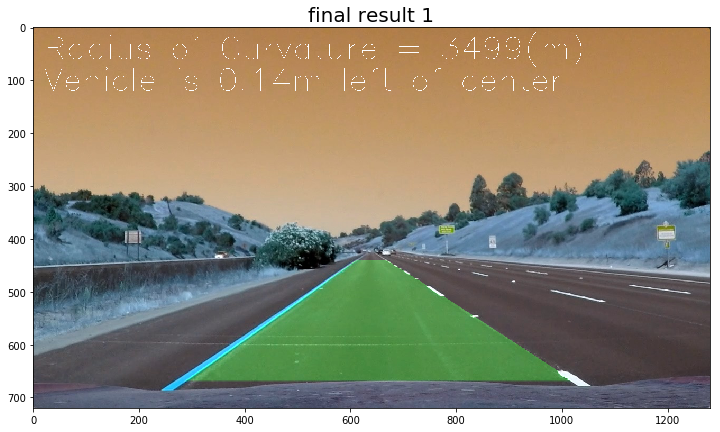

In [23]:
test_images = glob.glob('test_images/*.jpg')
image = cv2.imread(test_images[0])
out_img = process_image(image)
show_image(out_img, title='final result {}'.format(1))

# for i,img in enumerate(test_images):
#     image = cv2.imread(img)
#     out_img = process_image(image)
#     show_image(out_img, title='final result {}'.format(i+1))

In [ ]:
# vid_output = 'output_images/output_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(40,43)
# white_clip = clip1.fl_image(process_image) 
# %time white_clip.write_videofile(vid_output, audio=False)

In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(vid_output))